# LLM + RLHF Workshop

## Preliminary functions

In [1]:
import sys
!{sys.executable} -m pip install trl accelerate bitsandbytes loralib
!{sys.executable} -m pip install addict evaluate
!{sys.executable} -m pip install --upgrade git+https://github.com/huggingface/peft
!{sys.executable} -m pip install --upgrade git+https://github.com/huggingface/transformers
!{sys.executable} -m pip install --upgrade git+https://github.com/lvwerra/trl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 84.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [2]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.9 MB/s eta 0:00:00


In [3]:
!nvidia-smi

Sat May 27 07:48:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [7]:
import torch
import textwrap

device = "cuda" if torch.cuda.is_available() else "cpu"

EVAL_PROMPTS = [
    "Question: How to create an attention layer in pytorch? \n\n Answer: ",
    "Question: I recieve TypeError with a following code: ```a=[1, 2, 3]    a.extend(4)```. How can I fix it?  \n\n Answer: ",
    "Question: What library would you recommend for visualizing 3D points in python? \n\n Answer: ",
]

def generate_eval(model, tokenizer):
    print("Starting Evaluation...")
    model = model.to(device)
    model.eval()
    for eval_prompt in EVAL_PROMPTS:
        batch = tokenizer(eval_prompt, return_tensors="pt").to(device)

        with torch.cuda.amp.autocast():
            output_tokens = model.generate(**batch, max_new_tokens=128)

        print("\n\n", textwrap.fill(tokenizer.decode(output_tokens[0], skip_special_tokens=False)))
        print("*"*100)

### LoRA Adapters for SFT

In [8]:
import os
import addict
import torch
import peft
import bitsandbytes as bnb

from tqdm import tqdm
from torch.utils.data import IterableDataset
from peft import PeftModel, LoraConfig, get_peft_model, prepare_model_for_int8_training
from transformers import (
    Trainer,
    TrainingArguments,
    logging,
    set_seed,
    LlamaForCausalLM,
    LlamaTokenizer,
    LlamaConfig
)
from accelerate import Accelerator
from datasets import load_dataset

https://github.com/huggingface/peft/blob/main/src/peft/tuners/lora.py#L436

In [35]:
tokenizer = LlamaTokenizer.from_pretrained('decapoda-research/llama-7b-hf', eos_token = '</s>', add_eos_token=True)
tokenizer.pad_token_id = 0  # unk. we want this to be different from the eos token
tokenizer.padding_side = "left"
print(f'EOS token: {tokenizer.eos_token} EOS toke id: {tokenizer.eos_token_id}')
print(f'PAD token: {tokenizer.pad_token} PAD toke id: {tokenizer.pad_token_id}')
print(f'UNK token: {tokenizer.unk_token} UNK toke id: {tokenizer.unk_token_id}')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.


EOS token: </s> EOS toke id: 2
PAD token: <unk> PAD toke id: 0
UNK token:  UNK toke id: 0


In [42]:
configuration = LlamaConfig()

In [ ]:
# load model in 8bit
model = LlamaForCausalLM.from_pretrained(
    "decapoda-research/llama-7b-hf",
    load_in_8bit=True,
    device_map='auto'
)

model = prepare_model_for_int8_training(model)

In [44]:
print_trainable_parameters(model)

trainable params: 0 || all params: 6738415616 || trainable%: 0.0


In [45]:
# add LoRA to model
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()
model = get_peft_model(model, lora_config).to(device)

In [46]:
model.print_trainable_parameters()

trainable params: 8388608 || all params: 6746804224 || trainable%: 0.12433454005023165


In [83]:
dataset = load_dataset('Myashka/SO-Python_QA-API_Usage-tanh_score')

  0%|          | 0/3 [00:00<?, ?it/s]

In [41]:
tokenizer.batch_decode(tok_dict['input_ids'], skip_special_tokens=True)

['Since python is installed on nearly every non-Windows OS by default now, the only thing you really need to make sure of is that all of the non-standard libraries you use are installed.\nHaving said that, it is possible to build executables that include the python interpreter, and any libraries you use.  This is likely to create a large executable, however.\nMacOS X even includes support in the Xcode IDE for creating full standalone GUI apps.  These can be run by any user running OS X.']

In [ ]:
with torch.autocast("cuda"):
    generated_ids = model.generate(**tokenizer(dataset[0]['Question'], return_tensors='pt'), max_new_tokens=256)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1255: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1448: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:318: UserWarning: MatMul8bitLt: in

### Preparing Data for SFT

In [85]:
from tqdm import tqdm

In [151]:
class PackedQuestionAnswerDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.packed_samples = []
        self.max_length = max_length
        self.eos_token_id = tokenizer.eos_token_id
        self.pad_token_id = tokenizer.pad_token_id
        
        # Initially pack the questions and answers
        self._pack_inputs_and_labels(dataset)

    def _prepare_prompt(self, question):
        return f'Question: {question}\n\nAnswer:'

    def _pack_inputs_and_labels(self, dataset):
        input_buffer = []
        label_buffer = []
        for example in tqdm(dataset):
            question = self._prepare_prompt(example['Question'])
            answer = example['Answer']
            encoded_answer = self.tokenizer.encode(answer, add_special_tokens=False)
            encoded_question = self.tokenizer.encode(question, add_special_tokens=False)

            # Truncate the question from the end if the pair is too long
            if len(encoded_question) + len(encoded_answer) > self.max_length - 1:
                encoded_question = encoded_question[:self.max_length - len(encoded_answer) - 1]

            input_sequence = encoded_question + encoded_answer + [self.eos_token_id]
            label_sequence = [-100]*len(encoded_question) + encoded_answer + [self.eos_token_id]

            if len(input_buffer) + len(input_sequence) > self.max_length:
                # If adding the next sequence makes the input too long, add the current buffer as an item
                self.packed_samples.append({
                    "input_ids": input_buffer, 
                    "labels": label_buffer, 
                    "attention_mask": [1]*len(input_buffer)
                })
                input_buffer = input_sequence
                label_buffer = label_sequence
            else:
                # Otherwise, append the next sequence to the buffer
                input_buffer += input_sequence
                label_buffer += label_sequence

        # Add the last buffer if it is not empty and does not exceed max_length
        if input_buffer and len(input_buffer) <= self.max_length:
            self.packed_samples.append({
                "input_ids": input_buffer, 
                "labels": label_buffer, 
                "attention_mask": [1]*len(input_buffer)
            })

    def __len__(self):
        return len(self.packed_samples)

    def __getitem__(self, idx):
        sample = self.packed_samples[idx]
        input_ids = sample['input_ids']
        labels = sample['labels']
        attention_mask = sample['attention_mask']

        return {
            "input_ids": torch.tensor(input_ids), 
            "attention_mask": torch.tensor(attention_mask),
            "labels": torch.tensor(labels)
        }


In [152]:
from torch.utils.data import DataLoader, Dataset

In [153]:
tokenizer = LlamaTokenizer.from_pretrained('decapoda-research/llama-7b-hf', eos_token = '</s>')
tokenizer.pad_token_id = 0  # unk. we want this to be different from the eos token
tokenizer.padding_side = "left"

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.


In [154]:
train_dataset = PackedQuestionAnswerDataset(dataset['train'], tokenizer, 768)

100%|██████████| 6948/6948 [00:13<00:00, 509.94it/s]


In [159]:
print(tokenizer.decode(train_dataset[0]['input_ids'], skip_special_tokens=True))

Question: Python works on multiple platforms and can be used for desktop and web applications, thus I conclude that there is some way to compile it into an executable for Mac, Windows and Linux.
The problem being I have no idea where to start or how to write a GUI with it, can anybody shed some light on this and point me in the right direction please?

Answer: Since python is installed on nearly every non-Windows OS by default now, the only thing you really need to make sure of is that all of the non-standard libraries you use are installed.
Having said that, it is possible to build executables that include the python interpreter, and any libraries you use.  This is likely to create a large executable, however.
MacOS X even includes support in the Xcode IDE for creating full standalone GUI apps.  These can be run by any user running OS X. Question: Python works on multiple platforms and can be used for desktop and web applications, thus I conclude that there is some way to compile it i

In [135]:
tokenizer.decode([0, 2], skip_special_tokens=True)

''

In [121]:
len(train_dataset)

2098

In [136]:
print(tokenizer.decode(train_dataset[0]['input_ids'], skip_special_tokens=True))

Question: Python works on multiple platforms and can be used for desktop and web applications, thus I conclude that there is some way to compile it into an executable for Mac, Windows and Linux.
The problem being I have no idea where to start or how to write a GUI with it, can anybody shed some light on this and point me in the right direction please?

Answer: Since python is installed on nearly every non-Windows OS by default now, the only thing you really need to make sure of is that all of the non-standard libraries you use are installed.
Having said that, it is possible to build executables that include the python interpreter, and any libraries you use.  This is likely to create a large executable, however.
MacOS X even includes support in the Xcode IDE for creating full standalone GUI apps.  These can be run by any user running OS X. Question: Python works on multiple platforms and can be used for desktop and web applications, thus I conclude that there is some way to compile it i

In [76]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, return_tensors="pt", padding=True)
dataloader = DataLoader(train_dataset, batch_size=16, collate_fn=data_collator)

In [77]:
batch = next(iter(dataloader))

In [79]:
class PackedQuestionAnswerDataset(Dataset):
    def __init__(self, tokenizer, dataset, max_length):
        self.tokenizer = tokenizer
        self.packed_samples = []
        self.max_length = max_length
        self.eos_token_id = tokenizer.eos_token_id
        self.pad_token_id = tokenizer.pad_token_id
        
        # Initially pack the questions and answers
        self._pack_inputs_and_labels(dataset)

    def _pack_inputs_and_labels(self, dataset):
        input_buffer = []
        label_buffer = []
        for example in dataset:
            question = example['Question']
            answer = example['Answer']
            encoded_question = self.tokenizer.encode(question, add_special_tokens=False)
            encoded_answer = self.tokenizer.encode(answer, add_special_tokens=False)
            input_sequence = encoded_question + [self.eos_token_id] + encoded_answer
            label_sequence = [-100]*len(encoded_question) + [self.eos_token_id] + encoded_answer

            if len(input_buffer) + len(input_sequence) > self.max_length:
                # If adding the next sequence makes the input too long, add the current buffer as an item
                self.packed_samples.append({
                    "input_ids": input_buffer, 
                    "labels": label_buffer, 
                    "attention_mask": [1]*len(input_buffer)
                })
                input_buffer = input_sequence
                label_buffer = label_sequence
            else:
                # Otherwise, append the next sequence to the buffer
                input_buffer += input_sequence
                label_buffer += label_sequence

        # Add the last buffer if it is not empty and does not exceed max_length
        if input_buffer and len(input_buffer) <= self.max_length:
            self.packed_samples.append({
                "input_ids": input_buffer, 
                "labels": label_buffer, 
                "attention_mask": [1]*len(input_buffer)
            })

    def __len__(self):
        return len(self.packed_samples)

    def __getitem__(self, idx):
        sample = self.packed_samples[idx]
        input_ids = sample['input_ids']
        labels = sample['labels']
        attention_mask = sample['attention_mask']

        return {
            "input_ids": torch.tensor(input_ids), 
            "labels": torch.tensor(labels), 
            "attention_mask": torch.tensor(attention_mask)
        }


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'Dataset' is not defined

In [50]:
def create_datasets(tokenizer, cfg):
    
    def promt_tokenize(examples):
        a_toks = tokenizer.encode(examples['Answer'])

        if cfg.truncate_promt:
            q_toks = tokenizer.encode(examples['Question'])
            q_toks = q_toks[:cfg.max_length - len(a_toks)-8]
            tmp = tokenizer.decode(q_toks).strip()
        else:
            tmp = examples['Question']

        tmp = 'Question: ' + tmp + "\nAnswer:"
        q_toks = tokenizer.encode(tmp)

        sample = torch.tensor(q_toks + a_toks, dtype=int)
        sample = sample[:cfg.max_length]
        attention_mask = torch.ones(sample.shape, dtype=int)
        labels = sample.clone()
        labels[:len(q_toks)] = -100

        return {'input_ids': sample, 'attention_mask': attention_mask, 'labels': labels}

    dataset = load_dataset(
        cfg.dataset_name,
        num_proc=cfg.num_workers
    )
    train_data = dataset["train"]
    train_data = train_data.shuffle(seed=cfg.seed)
    valid_data = dataset['validation']
    print(f"Size of the train set: {len(train_data)}. Size of the validation set: {len(valid_data)}")

    train_data = train_data.map(promt_tokenize)
    train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    valid_data = valid_data.map(promt_tokenize)
    valid_data.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    return train_data, valid_data

### Config for SFT

In [ ]:
!pip install wandb

In [51]:
cfg = addict.Dict(
      {
        "num_train_epochs": 10,
        "batch_size": 16,
        "learning_rate": 1e-4,
        'max_grad_norm': 1,
        "gradient_accumulation_steps": 1,
        "lr_scheduler_type": "cosine",
        "fp16": True,
        "gradient_checkpointing": True,
        "weight_decay": 0.05,
        "warmup_ratio": 0.1,
        "output_dir": "./checkpoints",
        "log_freq": 15,
        'logging_first_step': True,
        "save_total_limit": 2,
        "eval_freq": 1000,
        "save_freq": 1000,
        "report_to": 'wandb',
        'run_name': 'wandb_run_name',
        "local_rank": 0,
        "seed": 42,
        "num_workers": 8,
       #####DATA#####
        "dataset_name": "Myashka/SO-Python_QA-API_Usage-tanh_score",
        "max_length": 768,
        "truncate_promt": True,
  }
)

In [52]:
train_dataset, eval_dataset = create_datasets(tokenizer, cfg)

  0%|          | 0/3 [00:00<?, ?it/s]

Size of the train set: 6948. Size of the validation set: 1000


Map:   0%|          | 0/6948 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

### Model Training

In [33]:
train_dataset.start_iteration = 0

print("Starting main loop")

training_args = TrainingArguments(
    output_dir=cfg.output_dir,
    dataloader_drop_last=True,
    evaluation_strategy="steps",
    num_train_epochs=cfg.num_train_epochs,
    eval_steps=cfg.eval_freq,
    save_steps=cfg.save_freq,
    logging_steps=cfg.log_freq,
    per_device_train_batch_size=cfg.batch_size,
    per_device_eval_batch_size=cfg.batch_size,
    learning_rate=cfg.learning_rate,
    lr_scheduler_type=cfg.lr_scheduler_type,
    warmup_steps=cfg.num_warmup_steps,
    gradient_accumulation_steps=cfg.gradient_accumulation_steps,
    gradient_checkpointing=cfg.gradient_checkpointing,
    fp16=cfg.fp16,
    weight_decay=cfg.weight_decay,
    save_total_limit=cfg.save_total_limit,
    report_to=cfg.report_to,
    run_name=cfg.run_name,
)
# print("Training...")
# trainer.train()

# print("Saving last checkpoint of the model")
# model.save_pretrained(os.path.join(cfg.output_dir, "final_checkpoint/"))

Starting main loop


In [45]:
import transformers

In [52]:
trainer = Trainer(model=model,
                  tokenizer=tokenizer,
                  args=training_args,
                  train_dataset=train_dataset,
                  eval_dataset=eval_dataset,
                  data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False))

In [53]:
data_loader = trainer.get_train_dataloader()

In [56]:
tokenizer.eos_token

''

In [54]:
next(iter(data_loader))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:633 in __next__           │
│                                                                                                  │
│    630 │   │   │   if self._sampler_iter is None:                                                │
│    631 │   │   │   │   # TODO(https://github.com/pytorch/pytorch/issues/76750)                   │
│    632 │   │   │   │   self._reset()  # type: ignore[call-arg]                                   │
│ ❱  633 │   │   │   data = self._next_data()                                                      │
│    634 │   │   │   self._num_yielded += 1                                                        │
│    635 │   │   │   if self._dataset_kind == _DatasetKind.Iterable and \                          │
│    636 │   │   │   │   │   self._IterableDataset_len_called is not None and \                    │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:677 in _next_data         │
│                                                                                                  │
│    674 │                                                                                         │
│    675 │   def _next_data(self):                                                                 │
│    676 │   │   index = self._next_index()  # may raise StopIteration                             │
│ ❱  677 │   │   data = self._dataset_fetcher.fetch(index)  # may raise StopIteration              │
│    678 │   │   if self._pin_memory:                                                              │
│    679 │   │   │   data = _utils.pin_memory.pin_memory(data, self._pin_memory_device)            │
│    680 │   │   return data                                                                       │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py:54 in fetch             │
│                                                                                                  │
│   51 │   │   │   │   data = [self.dataset[idx] for idx in possibly_batched_index]                │
│   52 │   │   else:                                                                               │
│   53 │   │   │   data = self.dataset[possibly_batched_index]                                     │
│ ❱ 54 │   │   return self.collate_fn(data)                                                        │
│   55                                                                                             │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/data/data_collator.py:45 in __call__        │
│                                                                                                  │
│     42 │   │   if return_tensors == "tf":                                                        │
│     43 │   │   │   return self.tf_call(features)                                                 │
│     44 │   │   elif return_tensors == "pt":                                                      │
│ ❱   45 │   │   │   return self.torch_call(features)                                              │
│     46 │   │   elif return_tensors == "np":                                                      │
│     47 │   │   │   return self.numpy_call(features)                                              │
│     48 │   │   else:                                       

### Merging and Uploading to HuggingFace Storage



<div>
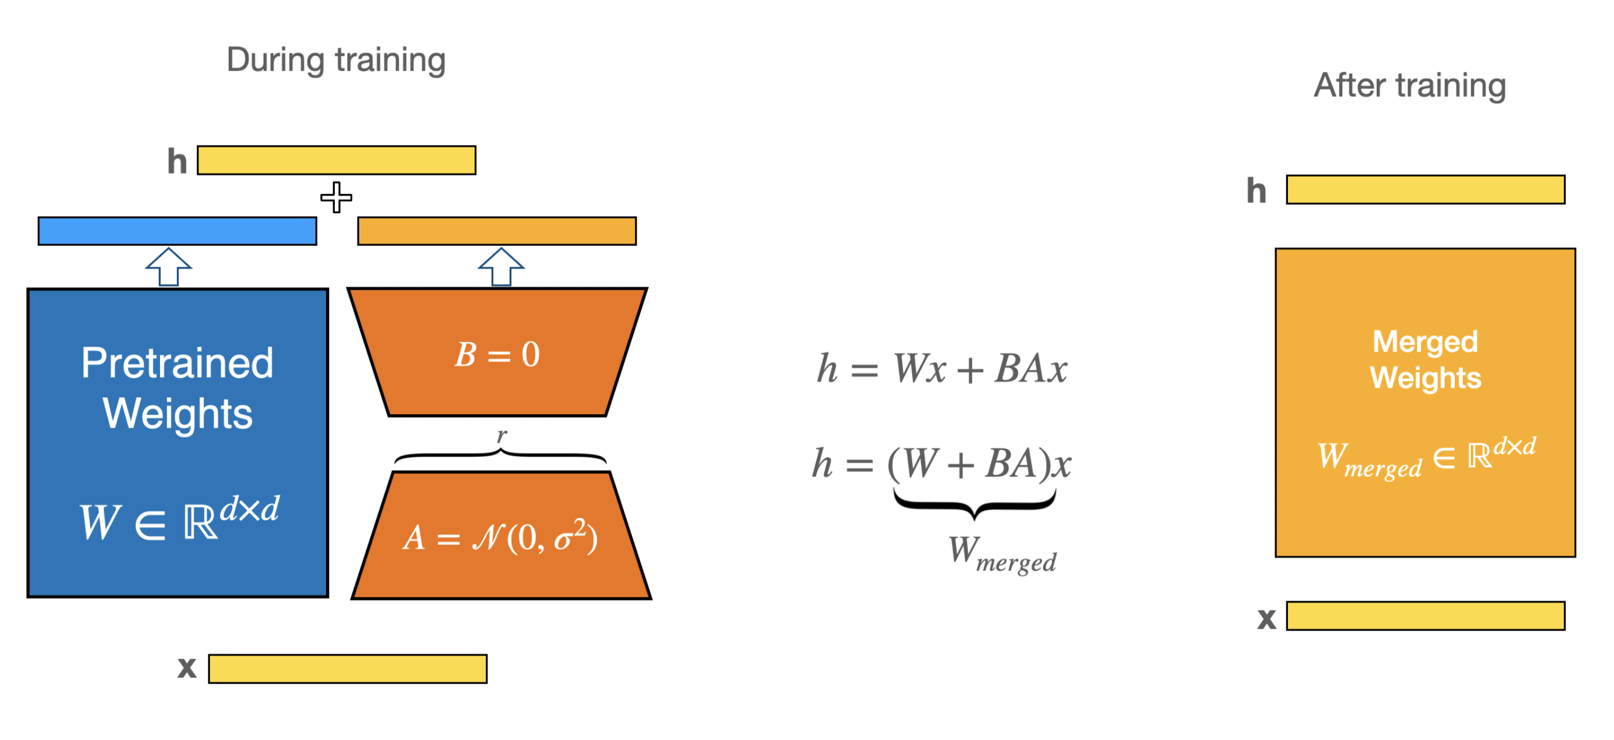
</div>

In [ ]:
model_sft = AutoModelForCausalLM.from_pretrained(
    "EleutherAI/gpt-neo-1.3B",
    torch_dtype=torch.float16,
    device_map={'':torch.cuda.current_device()}
)

model_sft = PeftModel.from_pretrained(model_sft, "./checkpoints/final_checkpoint")

In [ ]:
model_sft.save_pretrained(f"djalexj/gpt-neo-1.3B-sft-se-{cfg.max_steps}steps-lora")
model_sft.push_to_hub(f"djalexj/gpt-neo-1.3B-sft-se-{cfg.max_steps}steps-lora", use_temp_dir=False)

In [ ]:
model_sft = model_sft.merge_and_unload()
model_sft.save_pretrained(f"djalexj/gpt-neo-1.3B-sft-se-{cfg.max_steps}steps")
model_sft.push_to_hub(f"djalexj/gpt-neo-1.3B-sft-se-{cfg.max_steps}steps", use_temp_dir=False)

In [ ]:
# Load the Lora model
model = AutoModelForCausalLM.from_pretrained(f"djalexj/gpt-neo-1.3B-sft-se-4000steps")
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")

generate_eval(model, tokenizer)

Starting Evaluation...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.




 Question: How to create an attention layer in pytorch?    Answer:
``` import torch import torch.nn as nn import torch.nn.functional as F
class Attention(nn.Module):     def __init__(self, input_dim,
output_dim, attention_dim):         super(Attention, self).__init__()
self.input_dim = input_dim         self.output_dim = output_dim
self.attention_dim = attention_dim
****************************************************************************************************


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.




 Question: I recieve TypeError with a following code: ```a=[1, 2, 3]
a.extend(4)```. How can I fix it?     Answer:   ``` a = [1, 2, 3]
a.extend(4)  ```  This is because you are trying to extend an empty
list.  ``` a = [1, 2, 3] a.extend(4)  ```  This is because you are
trying to extend a list with a single element.  ``` a = [1, 2, 3]
a.extend(4)  ```  This is because you are trying to extend a list with
two elements.  ``
****************************************************************************************************


 Question: What library would you recommend for visualizing 3D points
in python?    Answer:   I would recommend the [3D-modeling
library](http://www.3dmodeling.com/). It is a very good library for 3D
modeling. It has a lot of features, including:  * A very good
documentation * A very good API * A very good community * A very good
community support * A very good community documentation * A very good
community forum * A very good community wiki * A very good community

## Reward Model (RM)

### RLHF

Reinforcement Learning from Human Feedback (RLHF) is a technique of training models by combining classical RL algorithms and human-generated evaluations of the model's outputs as a measure of performance. 

(c) ChatGPT-4


**It basically consists of:**


1.   Pretraining a language model (LM),
2.   Gathering data and training a reward model, and
3.   Fine-tuning the LM with reinforcement learning.






<div>
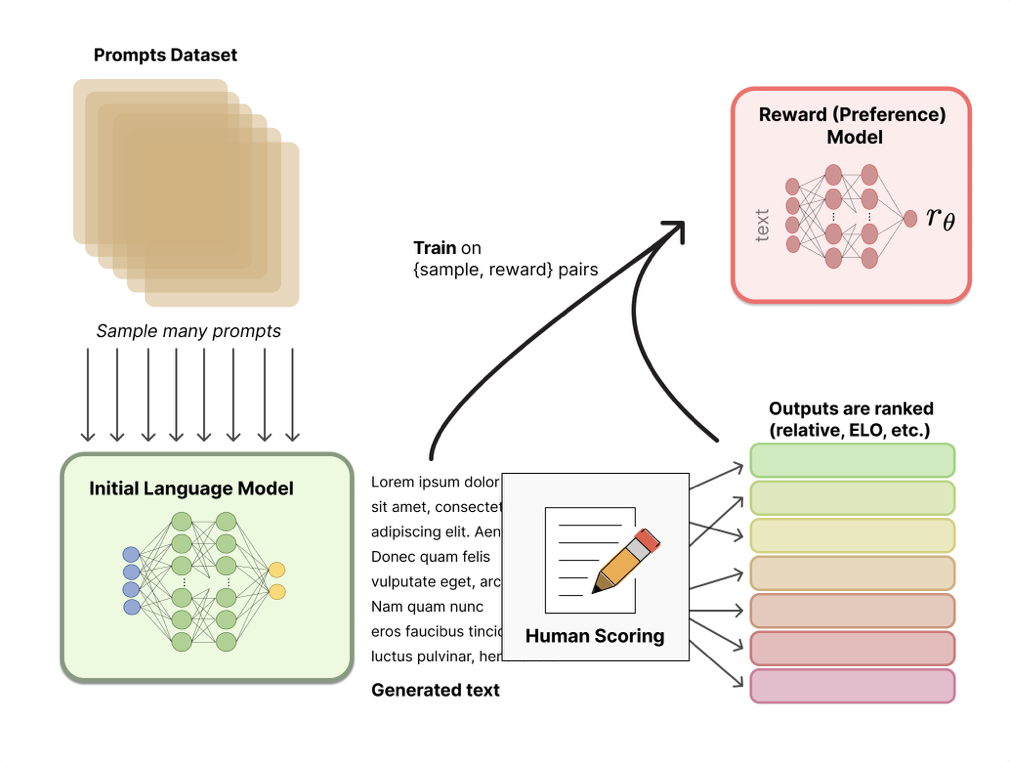
</div>

In [ ]:
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

import evaluate
import numpy as np
import torch
import torch.nn as nn
from datasets import load_dataset
from peft import LoraConfig, PeftModel, TaskType, get_peft_model, prepare_model_for_int8_training
import addict
from transformers import (
    AutoModel,
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    HfArgumentParser,
    PreTrainedTokenizerBase,
    Trainer,
    TrainingArguments,
)
from transformers.utils import PaddingStrategy

### Config for Reward Model

In [ ]:
cfg_reward = addict.Dict({
    "model_name": "bert-base-cased",
    "num_train_epochs": 1,
    "train_subset": 100_000,
    "eval_subset": 20_000,
    "gradient_accumulation_steps": 1,
    "gradient_checkpointing": True,
    "lr_scheduler_type": "linear",
    "weight_decay": 0.05,
    "learning_rate": 2e-5,
    "bf16": False,
    "fp16": False,
    ######
    "per_device_eval_batch_size": 64,
    "per_device_train_batch_size": 64,
    "local_rank": 0,
})

### Preparing Data for RM

In [ ]:
# Load the human stack-exchange-paired dataset for tuning the reward model
train_dataset = load_dataset("lvwerra/stack-exchange-paired", data_dir="data/reward", split="train")
if cfg_reward.train_subset > 0:
    train_dataset = train_dataset.select(range(cfg_reward.train_subset))
eval_dataset = load_dataset("lvwerra/stack-exchange-paired", data_dir="data/evaluation", split="train")
if cfg_reward.eval_subset > 0:
    eval_dataset = eval_dataset.select(range(cfg_reward.eval_subset))

model_name_split = cfg_reward.model_name.split("/")[-1]
output_name = (
    f"{model_name_split}_peft_stack-exchange-paired_rmts_{cfg_reward.train_subset}_{cfg_reward.learning_rate}"
)

original_columns = train_dataset.column_names
num_proc = 2  # Can adjust to be higher if you have more processors

In [ ]:
# Turn the dataset into pairs of post + summaries, where text_j is the preferred question + answer and text_k is the other.
# Then tokenize the dataset.
def preprocess_function(examples):
    new_examples = {
        "input_ids_j": [],
        "attention_mask_j": [],
        "input_ids_k": [],
        "attention_mask_k": [],
    }
    for question, response_j, response_k in zip(examples["question"], examples["response_j"], examples["response_k"]):
        tokenized_j = tokenizer("Question: " + question + "\n\nAnswer: " + response_j, truncation=True)
        tokenized_k = tokenizer("Question: " + question + "\n\nAnswer: " + response_k, truncation=True)

        new_examples["input_ids_j"].append(tokenized_j["input_ids"])
        new_examples["attention_mask_j"].append(tokenized_j["attention_mask"])
        new_examples["input_ids_k"].append(tokenized_k["input_ids"])
        new_examples["attention_mask_k"].append(tokenized_k["attention_mask"])

    return new_examples 


# preprocess the dataset and filter out QAs that are longer than 512
train_dataset = train_dataset.map(
    preprocess_function, batched=True, num_proc=num_proc, remove_columns=original_columns
)
train_dataset = train_dataset.filter(lambda x: len(x["input_ids_j"]) <= 512 and len(x["input_ids_k"]) <= 512)

eval_dataset = eval_dataset.map(preprocess_function, batched=True, num_proc=num_proc, remove_columns=original_columns)
eval_dataset = eval_dataset.filter(lambda x: len(x["input_ids_j"]) <= 512 and len(x["input_ids_k"]) <= 512)

In [ ]:
training_args = TrainingArguments(
    output_dir=output_name,
    learning_rate=cfg_reward.learning_rate,
    per_device_train_batch_size=cfg_reward.per_device_train_batch_size,
    per_device_eval_batch_size=cfg_reward.per_device_eval_batch_size,
    num_train_epochs=cfg_reward.num_train_epochs,
    weight_decay=cfg_reward.weight_decay,
    gradient_accumulation_steps=cfg_reward.gradient_accumulation_steps,
    gradient_checkpointing=cfg_reward.gradient_checkpointing,
    lr_scheduler_type=cfg_reward.lr_scheduler_type,
    bf16=cfg_reward.bf16,
    fp16=cfg_reward.fp16,
    evaluation_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    local_rank=cfg_reward.local_rank,
    logging_strategy="steps",
    logging_steps=10,
    remove_unused_columns=False,
    label_names=[],
)

### LoRA Adapters for RM

In [ ]:
# Load reward model as a SequenceClassification model with 1 label

tokenizer = AutoTokenizer.from_pretrained(cfg_reward.model_name)
config = AutoConfig.from_pretrained(cfg_reward.model_name)

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none"
)

model = AutoModelForSequenceClassification.from_pretrained(
    cfg_reward.model_name,
    num_labels=1,
    device_map={'':torch.cuda.current_device()}
)

model.enable_input_require_grads()
model = get_peft_model(model, peft_config)

model.print_trainable_parameters()

model.config.use_cache = not cfg_reward.gradient_checkpointing

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

trainable params: 591362 || all params: 108901634 || trainable%: 0.5430239917244951


In [ ]:
# We need to define a special data collator that batches the data in our j vs k format.
@dataclass
class RewardDataCollatorWithPadding:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    return_tensors: str = "pt"

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        features_j = []
        features_k = []
        for feature in features:
            features_j.append(
                {
                    "input_ids": feature["input_ids_j"],
                    "attention_mask": feature["attention_mask_j"],
                }
            )
            features_k.append(
                {
                    "input_ids": feature["input_ids_k"],
                    "attention_mask": feature["attention_mask_k"],
                }
            )
        batch_j = self.tokenizer.pad(
            features_j,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors=self.return_tensors,
        )
        batch_k = self.tokenizer.pad(
            features_k,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors=self.return_tensors,
        )
        batch = {
            "input_ids_j": batch_j["input_ids"],
            "attention_mask_j": batch_j["attention_mask"],
            "input_ids_k": batch_k["input_ids"],
            "attention_mask_k": batch_k["attention_mask"],
            "return_loss": True,
        }
        return batch


# Define the metric that we'll use for validation.
accuracy = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions, _ = eval_pred
    # Here, predictions is rewards_j and rewards_k.
    # We want to see how much of the time rewards_j > rewards_k.
    predictions = np.argmax(predictions, axis=0)
    labels = np.zeros(predictions.shape)
    return accuracy.compute(predictions=predictions, references=labels)

### Loss for RM

In [ ]:
class RewardTrainer(Trainer):
    # Define how to compute the reward loss. We use the InstructGPT pairwise logloss: https://arxiv.org/abs/2203.02155
    def compute_loss(self, model, inputs, return_outputs=False):
        rewards_j = model(input_ids=inputs["input_ids_j"], attention_mask=inputs["attention_mask_j"])[0]
        rewards_k = model(input_ids=inputs["input_ids_k"], attention_mask=inputs["attention_mask_k"])[0]
        loss = -nn.functional.logsigmoid(rewards_j - rewards_k).mean()
        if return_outputs:
            return loss, {"rewards_j": rewards_j, "rewards_k": rewards_k}
        return loss


# Train the model, woohoo.
trainer = RewardTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    data_collator=RewardDataCollatorWithPadding(tokenizer=tokenizer, max_length=512),
)

**InstructGPT original paper:** https://arxiv.org/pdf/2203.02155.pdf

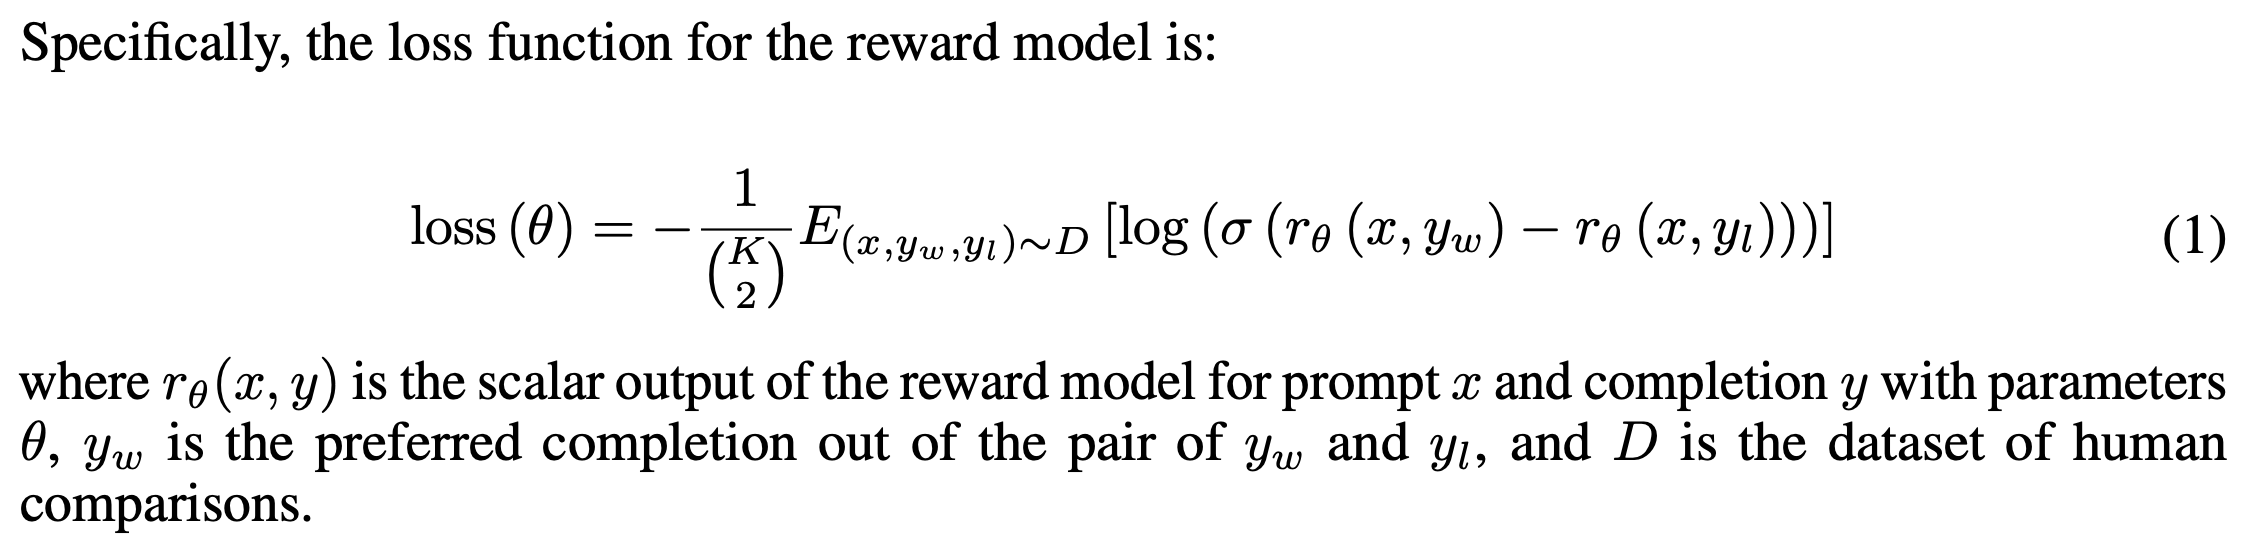

### Model Training

In [ ]:
trainer.train()

print("Saving last checkpoint of the model")
model.save_pretrained(output_name + "_peft_last_checkpoint")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Accuracy
500,0.668900,0.674774,0.653200
1000,0.677300,0.669907,0.661100
1500,0.690800,0.668485,0.662350


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Saving last checkpoint of the model


### Merging and Uploading to HuggingFace Storage

In [ ]:
model.save_pretrained(f"djalexj/bert-base-cased-rm-se-{cfg_reward.train_subset}steps-lora")
model.push_to_hub(f"djalexj/bert-base-cased-rm-se-{cfg_reward.train_subset}steps-lora", use_temp_dir=False)

In [ ]:
model_rm = model.merge_and_unload()

model_rm.save_pretrained(f"djalexj/bert-base-cased-rm-se-{cfg_reward.train_subset}steps")
model_rm.push_to_hub(f"djalexj/bert-base-cased-rm-se-{cfg_reward.train_subset}steps", use_temp_dir=False)

In [ ]:
# Load the Lora model
model_rm = AutoModelForSequenceClassification.from_pretrained(
    f"djalexj/bert-base-cased-rm-se-{cfg_reward.train_subset}steps",
    torch_dtype=torch.float16
).to(device)

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [ ]:
input1 = """
[CLS] Question : I just started using timber for logging on android, we are trying to add filenames / class - names to log message. 
I was able to add filenames in debug build using debug tree, but I'm not finding a way to add filenames in the release tree. 
Is there a possibility to add the filename in the release tree with R8 enabled? 
Answer : I got this error by having two different NavControllers in my compose hierarchy as a result of having a composable with a 
navController parameter : ` navController : NavController = rememberNavController ( ) ` 
but not setting it to a common, single root navController. [SEP]
"""

input2 = """
[CLS] Question : I just started using timber for logging on android, we are trying to add filenames / class - names to log message. 
I was able to add filenames in debug build using debug tree, but I'm not finding a way to add filenames in the release tree. 
Is there a possibility to add the filename in the release tree with R8 enabled? 
Answer : I got this because I had set popUpTo my firstFragment and also handled popBackStack onBackPressed. [SEP]
"""

tokens1, tokens2 = (
    tokenizer(input1, truncation=True, return_tensors="pt").to(device),
    tokenizer(input2, truncation=True, return_tensors="pt").to(device),
)

In [ ]:
model_rm.eval()

with torch.no_grad():
    print(f"Input1 Reward estimation: {model_rm(**tokens1)[0].item():.3f}")
    print(f"Input2 Reward estimation: {model_rm(**tokens2)[0].item():.3f}")

Input1 Reward estimation: 0.166
Input2 Reward estimation: 0.106



## RL Fine-Tuning

<div>
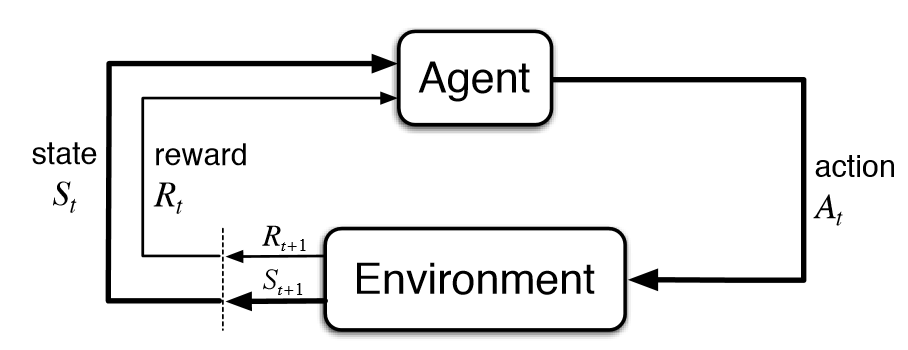
</div>

$R = \sum_{t=0}^T γ^tr_t$ -- Sum of discounted rewards

$V_\pi(s) = \mathbb{E}\big[R | s_0 = s\big] = \mathbb{E} \big[R | s \big]$ -- Value function (expected return starting with state s)

$Q_\pi(s, a) = \mathbb{E}\big[ R | s, a\big]$ -- Action-value function (expected return starting with state s taking action a)

$A_\pi(s, a) = Q_\pi(s, a) - V_\pi(s)$


<div>
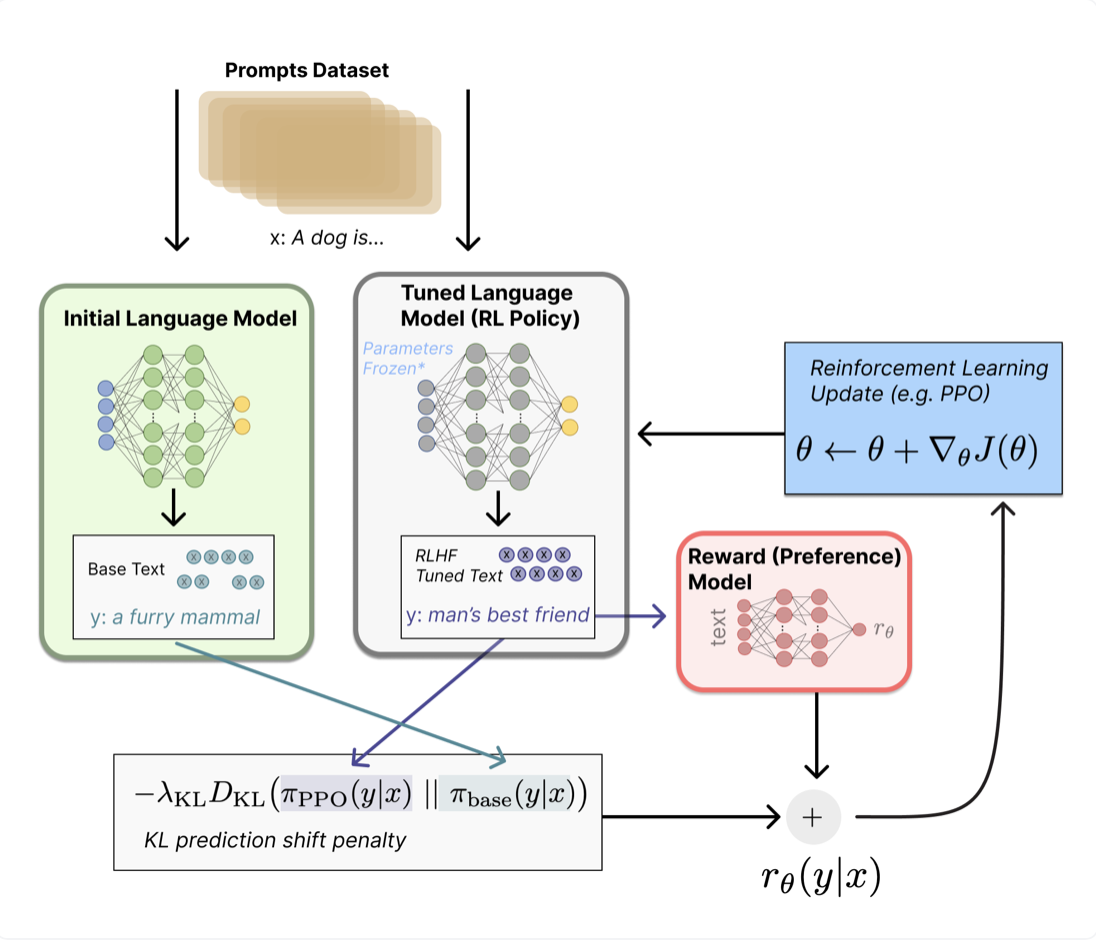
</div>

In [ ]:
from dataclasses import dataclass, field
from typing import Optional

import torch
import addict
from accelerate import Accelerator
from datasets import load_dataset
from peft import PeftModel, LoraConfig, get_peft_model, prepare_model_for_int8_training
from tqdm import tqdm
from transformers import (
    Adafactor,
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    HfArgumentParser,
    pipeline,
    AutoModelForSequenceClassification
)

from trl import AutoModelForCausalLMWithValueHead, PPOConfig, PPOTrainer, set_seed
from trl.core import LengthSampler

### Config for PPO

In [ ]:
ppo_config = addict.Dict({
    "model_name": "djalexj/gpt-neo-1.3B-sft-se-4000steps",
    "tokenizer_name": "EleutherAI/gpt-neo-1.3B",
    "reward_model_name": "djalexj/bert-base-cased-rm-se-100000steps",
    "reward_tokenizer_name": "bert-base-cased",
    ######
    "learning_rate": 1.4e-5,
    "output_max_length": 128,
    "mini_batch_size": 2,
    "batch_size": 16,
    "ppo_epochs": 3,
    "gradient_accumulation_steps": 4,
    "adafactor": False,
    "early_stopping": True,
    "target_kl": 0.1,
    "reward_baseline": 0.0,
    #######
    "batched_gen": True,
    "save_freq": 50,
    "output_dir": "gpt-neo-1.3B-rlhf-se",
    "seed": 0,
    "log_with": None,

})

In [ ]:
tqdm.pandas()

reward_model_name = ppo_config.reward_model_name
dataset_name = "lvwerra/stack-exchange-paired"

rl_config = PPOConfig(
    model_name=ppo_config.model_name,
    learning_rate=ppo_config.learning_rate,
    log_with=ppo_config.log_with,
    batch_size=ppo_config.batch_size,
    mini_batch_size=ppo_config.mini_batch_size,
    gradient_accumulation_steps=ppo_config.gradient_accumulation_steps,
    optimize_cuda_cache=True,
    early_stopping=ppo_config.early_stopping,
    target_kl=ppo_config.target_kl,
    ppo_epochs=ppo_config.ppo_epochs,
    seed=ppo_config.seed,
)

### Preparing Data

In [ ]:
train_dataset = load_dataset("lvwerra/stack-exchange-paired", data_dir="data/rl", split="train")
train_dataset = train_dataset.select(range(100000))
# We then define the arguments to pass to the sentiment analysis pipeline.
# We set `return_all_scores` to True to get the sentiment score for each token.
sent_kwargs = {"top_k": None, "function_to_apply": "none", "batch_size": 16, "truncation": True}

reward_tokenizer = AutoTokenizer.from_pretrained(ppo_config.reward_tokenizer_name)
tokenizer = AutoTokenizer.from_pretrained(ppo_config.tokenizer_name)
# GPT-2 tokenizer has a pad token, but it is not eos_token by default. We need to set it to eos_token.
# only for this model.
tokenizer.pad_token = tokenizer.eos_token


# Below is an example function to build the dataset. One should customize this function to train the model on
# its own dataset.
def build_dataset(
    tokenizer, dataset_name="lvwerra/stack-exchange-paired", input_min_text_length=2, input_max_text_length=8
):
    """
    Build dataset for training. This builds the dataset from `load_dataset`, one should
    customize this function to train the model on its own dataset.
    Args:
        dataset_name (`str`):
            The name of the dataset to be loaded.
    Returns:
        dataloader (`torch.utils.data.DataLoader`):
            The dataloader for the dataset.
    """

    ds = load_dataset(dataset_name, data_dir="data/rl", split="train")
    original_columns = ds.column_names
    num_proc = 2

    def preprocess_function(examples):
        new_examples = {
            "query": [],
            "input_ids": [],
        }
        for question in examples["question"]:
            query = "Question: " + question + "\n\nAnswer: "
            tokenized_question = tokenizer(query, truncation=True)
            new_examples["query"].append(query)
            new_examples["input_ids"].append(tokenized_question["input_ids"])

        return new_examples

    ds = train_dataset.map(
        preprocess_function,
        batched=True,
        num_proc=num_proc,
        remove_columns=original_columns,
    )
    ds = ds.filter(lambda x: len(x["input_ids"]) < 512, batched=False)

    ds.set_format(type="torch")
    return ds


# We retrieve the dataloader by calling the `build_dataset` function.
dataset = build_dataset(tokenizer)


def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])


# set seed before initializing value head for deterministic eval
set_seed(rl_config.seed)

### LoRA Adapters for RL fine-tune

In [ ]:
# Now let's build the model, the reference model, and the tokenizer.
pretrained_model = AutoModelForCausalLM.from_pretrained(
    rl_config.model_name, 
    load_in_8bit=True, 
    device_map={"": torch.cuda.current_device()}
)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

pretrained_model = prepare_model_for_int8_training(pretrained_model)
pretrained_model.enable_input_require_grads()
pretrained_model = get_peft_model(pretrained_model, lora_config)

pretrained_model.print_trainable_parameters()

# Use trl wrapper for additional ValueHead (critic)
model = AutoModelForCausalLMWithValueHead.from_pretrained(pretrained_model)

optimizer = None
if ppo_config.adafactor:
    optimizer = Adafactor(
        filter(lambda p: p.requires_grad, model.parameters()),
        scale_parameter=False,
        relative_step=False,
        warmup_init=False,
        lr=rl_config.learning_rate,
    )

### Model Training

In [ ]:
# We then build the PPOTrainer, passing the model, the reference model, the tokenizer
ppo_trainer = PPOTrainer(
    config=rl_config,
    model=model,
    ref_model=None,
    tokenizer=tokenizer,
    dataset=dataset,
    data_collator=collator,
    optimizer=optimizer,
)

In [ ]:
# We then build the sentiment analysis pipeline, passing the model name and the
# sentiment analysis pipeline arguments. Let's also make sure to set the device
# to the same device as the PPOTrainer.
device = ppo_trainer.accelerator.device
if ppo_trainer.accelerator.num_processes == 1:
    device = 0 if torch.cuda.is_available() else "cpu"  # to avoid a `pipeline` bug


reward_model = AutoModelForSequenceClassification.from_pretrained(
    ppo_config.reward_model_name
)

sentiment_pipe = pipeline(
    "sentiment-analysis",
    model=reward_model,
    device_map={"": torch.cuda.current_device()},
    tokenizer=reward_tokenizer,
)

# We then define the arguments to pass to the `generate` function. These arguments
# are passed to the `generate` function of the PPOTrainer, which is a wrapper around
# the `generate` function of the trained model.
generation_kwargs = {
    # "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.pad_token_id,
    "eos_token_id": tokenizer.eos_token_id,
}
output_min_length = 32
output_max_length = ppo_config.output_max_length
output_length_sampler = LengthSampler(output_min_length, output_max_length)

Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


<div>
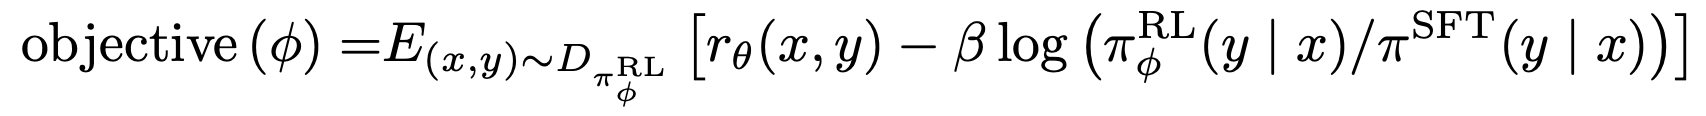
</div>

In [ ]:
for epoch, batch in tqdm(enumerate(ppo_trainer.dataloader)):
    question_tensors = batch["input_ids"]

    response_tensors = ppo_trainer.generate(
        question_tensors,
        return_prompt=False,
        length_sampler=output_length_sampler,
        **generation_kwargs,
    )
    batch["response"] = tokenizer.batch_decode(response_tensors, skip_special_tokens=True)

    # Compute sentiment score
    texts = [q + r for q, r in zip(batch["query"], batch["response"])]
    pipe_outputs = sentiment_pipe(texts, **sent_kwargs)
    rewards = [torch.tensor(output[0]["score"] - ppo_config.reward_baseline) for output in pipe_outputs]

    # Run PPO step
    stats = ppo_trainer.step(question_tensors, response_tensors, rewards)
    ppo_trainer.log_stats(stats, batch, rewards)

    if ppo_config.save_freq and epoch and epoch % ppo_config.save_freq == 0:
        ppo_trainer.save_pretrained(ppo_config.output_dir + f"step_{epoch}")

https://github.com/lvwerra/trl/blob/main/trl/trainer/ppo_trainer.py#L537

<div>
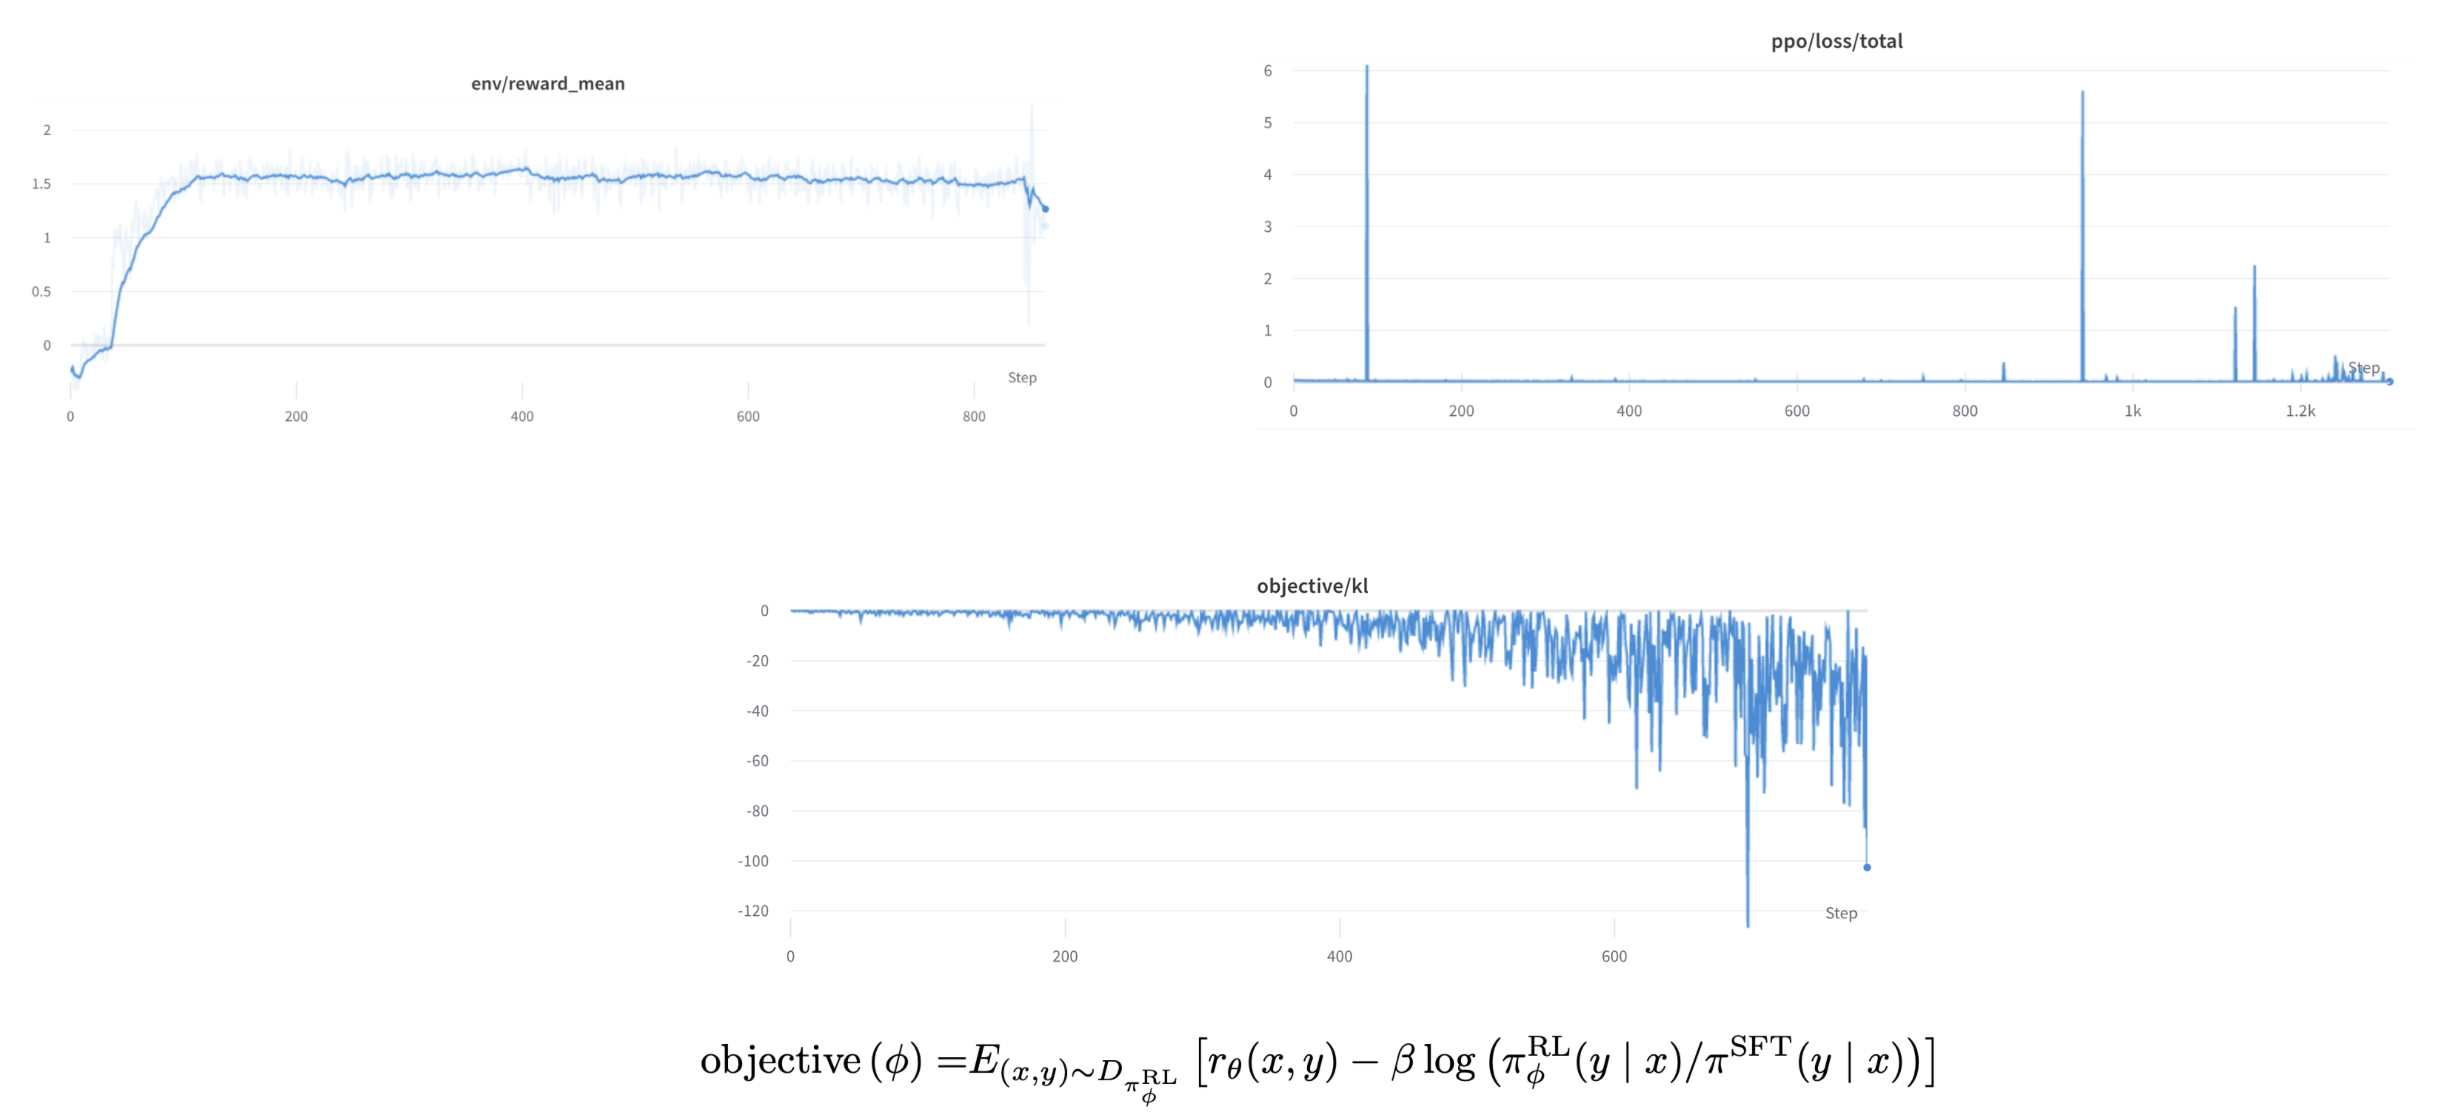
</div>

### Merging and Uploading to HuggingFace Storage

In [ ]:
model_rlhf = AutoModelForCausalLM.from_pretrained(
    "djalexj/gpt-neo-1.3B-sft-se-4000steps",
    torch_dtype=torch.float16,
    device_map={'':torch.cuda.current_device()}
)

model_rlhf = PeftModel.from_pretrained(model_rlhf, "./gpt-neo-1.3B-rlhf-sestep_250")

model_rlhf.save_pretrained(f"djalexj/gpt-neo-1.3B-rlhf-se-250steps-lora-latest")
model_rlhf.push_to_hub(f"djalexj/gpt-neo-1.3B-rlhf-se-250steps-lora-latest", use_temp_dir=False)

model_rlhf = model_rlhf.merge_and_unload()
model_rlhf.save_pretrained(f"djalexj/gpt-neo-1.3B-rlhf-se-250steps-latest")
model_rlhf.push_to_hub(f"djalexj/gpt-neo-1.3B-rlhf-se-250steps-latest", use_temp_dir=False)

In [ ]:
model = AutoModelForCausalLM.from_pretrained("djalexj/gpt-neo-1.3B-rlhf-se-250steps-latest")
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")

generate_eval(model, tokenizer)

Starting Evaluation...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.




 Question: How to create an attention layer in pytorch?    Answer:
``` import torch import torch.nn as nn import torch.nn.functional as F
class Attention(nn.Module):     def __init__(self, input_dim,
output_dim, attention_dim):         super(Attention, self).__init__()
self.input_dim = input_dim         self.output_dim = output_dim
self.attention_dim = attention_dim
****************************************************************************************************


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.




 Question: I recieve TypeError with a following code: ```a=[1, 2, 3]
a.extend(4)```. How can I fix it?     Answer:   ``` a = [1, 2, 3]
a.extend(4)  ```  This is because you are trying to extend an empty
list.  You can use the `extend` method to extend a list with another
list.  ``` a = [1, 2, 3] a.extend([4])  ```  This will give you a list
with 4 elements.  ``` a = [1, 2, 3] a.extend([4])  ```  This will give
****************************************************************************************************


 Question: What library would you recommend for visualizing 3D points
in python?    Answer:   I would recommend the
[`pyOpenGL`](http://pyopengl.sourceforge.net/) library. It is a very
powerful library that can be used to create 3D graphics. It is very
easy to use and has a very good documentation.  I have used it to
create a 3D model of a car. It is very easy to use and has a very good
documentation.  I have also used it to create a 3D model of a house.
It is very easy to use

All models are available in https://huggingface.co/djalexj

If have any questions, DM me in Singularis (@alex_golubev) or LinkedIn (https://www.linkedin.com/in/alexander-golubev-79064117b/)



---



## References:
### Papers:
Instruct GPT - https://arxiv.org/abs/2203.02155

LLM.int8() quantization - https://arxiv.org/abs/2208.07339

LoRA adapters - https://arxiv.org/abs/2106.09685

PPO algorithm - https://arxiv.org/abs/1707.06347

### Sources:
TRL ppo implementation - https://github.com/lvwerra/trl/blob/main/trl/trainer/ppo_trainer.py

Efficient single-GPU training - https://huggingface.co/docs/transformers/perf_train_gpu_one

HuggingFace StackExchange Dataset - https://huggingface.co/datasets/HuggingFaceH4/stack-exchange-preferences (https://huggingface.co/datasets/lvwerra/stack-exchange-paired)

HuggingFace posts on fine-tuning LLMs:


1.   Fine-tuning 20B LLMs with RLHF on a 24GB consumer GPU - https://huggingface.co/blog/trl-peft
2.   StackLLaMA: A hands-on guide to train LLaMA with RLHF - https://huggingface.co/blog/stackllama


